#Importing Libraries

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
import cv2
from skimage import segmentation
from skimage.segmentation import slic
from skimage.color import label2rgb
import os
from google.colab import drive

In [ ]:
from skimage.data import astronaut
from skimage.segmentation import slic
from scipy.spatial import Delaunay
from skimage.segmentation import mark_boundaries
from matplotlib.lines import Line2D

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Data Analysis

In [ ]:
print(os.listdir("/content/drive/MyDrive/MNIST_dataset"))

['HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'base_dir']


In [ ]:
path='/content/drive/MyDrive/MNIST_dataset/'
csv_file='/content/drive/MyDrive/MNIST_dataset/HAM10000_metadata.csv'

In [ ]:
df=pd.read_csv(csv_file)

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['dx_labels'] = df['dx'].map(lesion_type_dict)

In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_labels
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis


In [ ]:
print(df.dx.value_counts())

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


Persebaran data sangat jauh, oleh karena itu jumlah data perlu di samakan

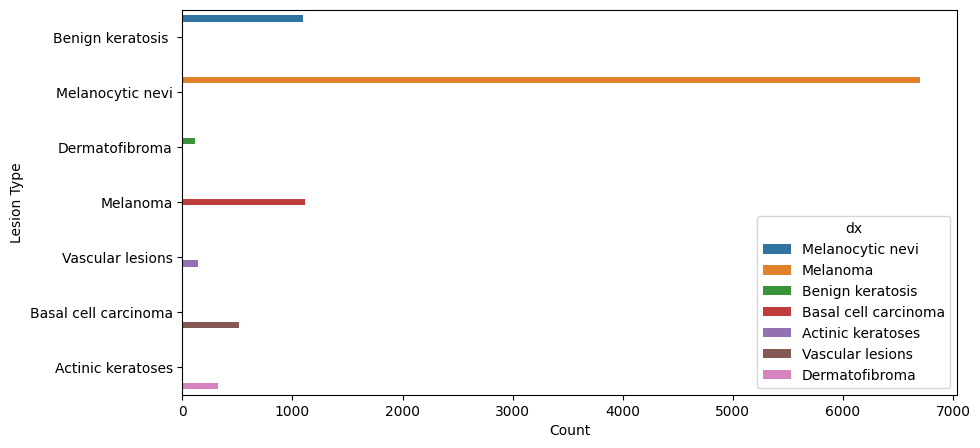

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
sns.countplot(y='dx_labels', data=df, hue='dx', ax=ax1)

ax1.set(ylabel="Lesion Type")
plt.xlabel("Count")
plt.legend(title="dx", loc='lower right', labels=[lesion_type_dict[key] for key in lesion_type_dict])

plt.show()

In [ ]:
#membuat folder baru untuk menyimpan data train dan test,
#dipisah sesuai dengan kelasnya masing-masing pada folder
base_dir = 'base_dir'
os.mkdir(base_dir)

# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# test_dir
test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)


In [ ]:
#train
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

In [ ]:
#test
nv = os.path.join(test_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(test_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(test_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(test_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(test_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(test_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(test_dir, 'df')
os.mkdir(df)

In [ ]:
from sklearn.model_selection import train_test_split
y = df['dx']
X = df.drop(['dx'], axis =1)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)

In [ ]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [ ]:
df2= X_resampled.join(y_resampled)
df2['dx'].value_counts()

akiec    115
bcc      115
bkl      115
df       115
mel      115
nv       115
vasc     115
Name: dx, dtype: int64

Data sudah tersebar rata setiap kelasnya

In [ ]:
df_train, df_test = train_test_split(df2, test_size=0.3, random_state=101, stratify=y_resampled)

In [ ]:
import shutil
df.set_index('image_id', inplace=True)

folder_1 = os.listdir('/content/drive/MyDrive/MNIST_dataset/HAM10000_images_part_1')
folder_2 = os.listdir('/content/drive/MyDrive/MNIST_dataset/HAM10000_images_part_2')
# Get a list of train and val images
train_list = list(df_train['image_id'])
test_list = list(df_test['image_id'])


# Transfer the train images
for image in train_list:

    fname = image + '.jpg'
    label = df.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/MNIST_dataset/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/MNIST_dataset/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the test images

for image in test_list:

    fname = image + '.jpg'
    label = df.loc[image,'dx']

    if fname in folder_1:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/MNIST_dataset/HAM10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(test_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('/content/drive/MyDrive/MNIST_dataset/HAM10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(test_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

#Visualization

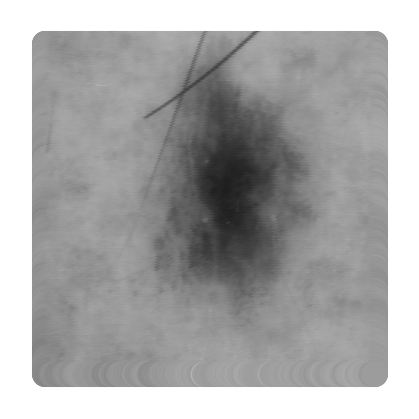

In [ ]:


# Load an example image (replace 'your_image.jpg' with your image file path)
image_path = '/content/ISIC_0024306.jpg'
img = io.imread(image_path)

# Convert the image to grayscale if it's in color
if len(img.shape) == 3:
    img = rgb2gray(img)

# Create a graph
G = nx.Graph()

# Get image dimensions
height, width = img.shape

# Add nodes to the graph
for y in range(height):
    for x in range(width):
        pixel_value = img[y, x]
        G.add_node((x, y), intensity=pixel_value)

# Add edges to represent spatial relationships (e.g., 4-connectivity)
for y in range(height):
    for x in range(width):
        if x < width - 1:
            G.add_edge((x, y), (x + 1, y))
        if y < height - 1:
            G.add_edge((x, y), (x, y + 1))

# Visualize the graph (optional)
pos = {(x, y): (x, -y) for x, y in G.nodes()}  # Reverse y-coordinates for a top-down view
node_colors = [G.nodes[node]['intensity'] for node in G.nodes()]
plt.figure(figsize=(4, 4))
nx.draw(G, pos, with_labels=False, node_size=300, node_color=node_colors, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

In [ ]:
image = cv2.imread('/content/ISIC_0024306.jpg')
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
num_superpixels = 300
segments = slic(image, n_segments=num_superpixels, compactness=25)

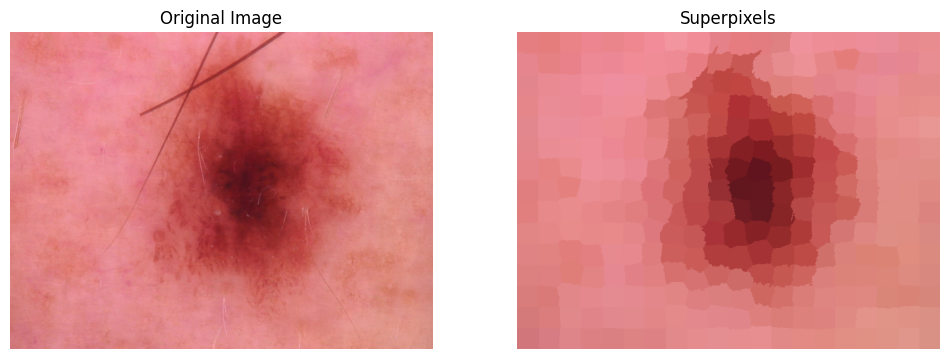

In [ ]:
superpixel_image = label2rgb(segments, image=img_rgb, kind='avg', bg_label=0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_rgb)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(superpixel_image)
ax[1].set_title('Superpixels')
ax[1].axis('off')

plt.show()

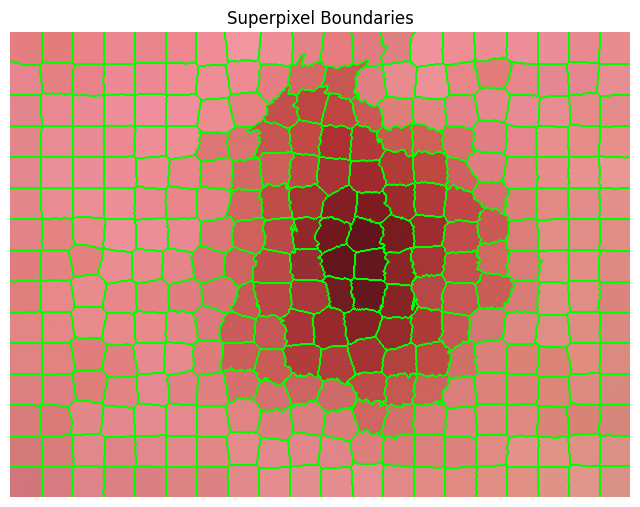

In [ ]:
from skimage.segmentation import mark_boundaries
superpixel_boundaries = mark_boundaries(superpixel_image, segments, color=(0, 1, 0), outline_color=None)

plt.figure(figsize=(8, 8))
plt.imshow(superpixel_boundaries)
plt.title('Superpixel Boundaries')
plt.axis('off')
plt.show()


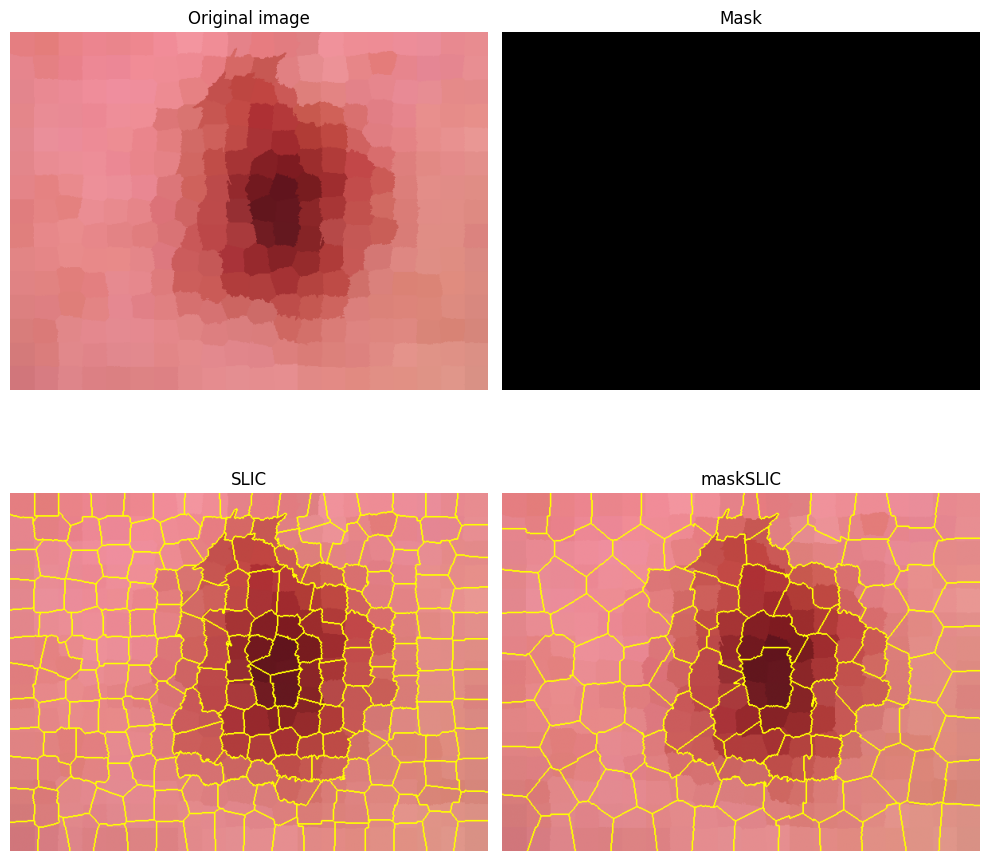

In [ ]:
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation

img = superpixel_image

lum = color.rgb2gray(img)
mask = morphology.remove_small_holes(
    morphology.remove_small_objects(
        lum < 0.7, 500),
    500)

mask = morphology.opening(mask, morphology.disk(3))

slic = segmentation.slic(img, n_segments=200, start_label=1)

m_slic = segmentation.slic(img, n_segments=100, mask=mask, start_label=1)

fig, ax_arr = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
ax1, ax2, ax3, ax4 = ax_arr.ravel()

ax1.imshow(img)
ax1.set_title('Original image')

ax2.imshow(mask, cmap='gray')
ax2.set_title('Mask')

ax3.imshow(segmentation.mark_boundaries(img, slic))
ax3.contour(mask, colors='red', linewidths=1)
ax3.set_title('SLIC')

ax4.imshow(segmentation.mark_boundaries(img, m_slic))
ax4.contour(mask, colors='red', linewidths=1)
ax4.set_title('maskSLIC')

for ax in ax_arr.ravel():
    ax.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
segments = segmentation.slic(superpixel_image, n_segments=200, compactness=20)
segments_ids = np.unique(segments)
centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

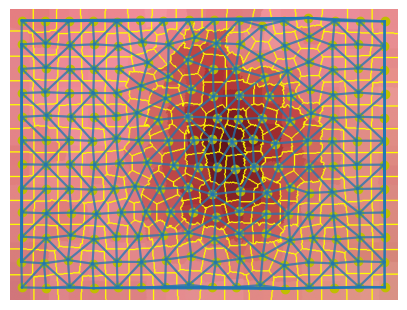

In [ ]:
tri = Delaunay(centers)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
plt.imshow(mark_boundaries(superpixel_image, segments))
plt.scatter(centers[:,1],centers[:,0], c='y')

indptr,indices = tri.vertex_neighbor_vertices

for i in range(len(indptr)-1):
    N = indices[indptr[i]:indptr[i+1]]
    centerA = np.repeat([centers[i]], len(N), axis=0)
    centerB = centers[N]

    for y0,x0,y1,x1 in np.hstack([centerA,centerB]):
        l = Line2D([x0,x1],[y0,y1], alpha=0.5)
        ax.add_line(l)
plt.axis('off')
plt.show()

#Looping throughout the dataset while doing the same thing

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def make_new_folder(path):
  new_folder = os.path.join(folder,'del_data')

  if not os.path.exists(new_folder):
      # Create the new folder
      os.makedirs(new_folder)
      print(f"Folder '{new_folder}' created successfully.")
  else:
      print(f"Folder '{new_folder}' already exists.")

  return new_folder

In [ ]:
folder = '/content/drive/MyDrive/MNIST_dataset/HAM10000_images_part_1/'
# temp = '/content/drive/MyDrive/MNIST_dataset/HAM10000_images_part_1/'
# print(f'{temp}{folder1}')

saving_path = make_new_folder(folder)

for files in os.listdir(folder):
  img_path = os.path.join(folder,files)

  img= cv2.imread(img_path)
  img_rgb= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


  num_superpixels = 300
  segments = slic(img, n_segments=num_superpixels, compactness=25)


  superpixel_image = label2rgb(segments, image=img_rgb, kind='avg', bg_label=0)
  # sup_rgb = cv2.cvtColor(superpixel_image, cv2.COLOR_BGR2RGB)
  # cv2_imshow(sup_rgb)
  superpixel_boundaries = mark_boundaries(superpixel_image, segments, color=(0, 1, 0), outline_color=None)


  segments = slic(superpixel_image, n_segments=200, compactness=20)
  segments_ids = np.unique(segments)
  centers = np.array([np.mean(np.nonzero(segments==i),axis=1) for i in segments_ids])

  tri = Delaunay(centers)

  # draw centers and neighbors
  fig = plt.figure(figsize=(7,7))
  ax = fig.add_subplot(111)
  plt.imshow(mark_boundaries(superpixel_image, segments))
  plt.scatter(centers[:,1],centers[:,0], c='y')

  # this contains the neighbors list: tri.vertex_neighbor_vertices
  indptr,indices = tri.vertex_neighbor_vertices

  # draw lines from each center to its neighbors
  for i in range(len(indptr)-1):
      N = indices[indptr[i]:indptr[i+1]] # list of neighbor superpixels
      centerA = np.repeat([centers[i]], len(N), axis=0)
      centerB = centers[N]

      for y0,x0,y1,x1 in np.hstack([centerA,centerB]):
          l = Line2D([x0,x1],[y0,y1], alpha=0.5)
          ax.add_line(l)

  # save_path = new_folder
  plt.axis('off')
  plt.savefig(f'{saving_path}/delauney{files}')


#Pre-Processing

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.6 MB/s eta 0:00:00


In [ ]:
from torch.nn import Linear, ReLU, Softmax, Sequential, Dropout
from torch_geometric.nn.models.schnet import Sequential
from torch_geometric.nn import global_mean_pool, global_max_pool, EdgeConv

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Batch, Data
from torch_geometric.loader import DataLoader

from torch_geometric.transforms import ToSLIC, Delaunay, FaceToEdge

from torchvision.transforms.transforms import ToTensor
import torchvision.transforms as T

In [ ]:
train_path = '/content/drive/MyDrive/MNIST_dataset/base_dir/content/base_dir/train_dir'
train_path = '/content/drive/MyDrive/MNIST_dataset/base_dir/content/base_dir/train_dir'
test_path = '/content/drive/MyDrive/MNIST_dataset/base_dir/content/base_dir/test_dir'

In [ ]:
data_total_valid = []
data_total_test = []
data_total_temp = []
data_total = []

In [ ]:
transform = T.Compose([ToTensor(),ToSLIC(n_segments=50), Delaunay(), FaceToEdge()])

In [ ]:
for i, classes in enumerate(os.listdir(train_path)):
  folders = os.path.join(train_path, classes)

  if classes in ['delauney_data']:
    continue
  else:
    for files in os.listdir(folders):
      img_path= os.path.join(folders, files)
      img = cv2.imread(img_path)
      img_transform = transform(img)
      img_transform.y = i
      data_total.append(img_transform)

In [ ]:
for i, classes in enumerate(os.listdir(test_path)):
  folders = os.path.join(test_path, classes)

  if classes in ['delauney_data']:
    continue
  else:
    for files in os.listdir(folders):
      img_path= os.path.join(folders, files)
      img = cv2.imread(img_path)
      img_transform = transform(img)
      img_transform.y = i
      data_total_temp.append(img_transform)

#Modelling

In [ ]:
from sklearn.model_selection import train_test_split

data_total_valid, data_total_test = train_test_split(data_total_temp,test_size=0.5, random_state=123)

In [ ]:
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.conv4 = GCNConv(hidden_dim, hidden_dim)

        self.lin = Linear(hidden_dim, output_dim)

    def forward(self,x, edge_index,batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p = 0.3)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = F.softmax(x,-1)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [ ]:
input_dim = 3
hidden_dim = 64
output_dim = 7
model = GCNModel(input_dim, hidden_dim, output_dim)

loader = DataLoader(data_total, batch_size = 32, shuffle = True)
val_loader = DataLoader(data_total_valid, batch_size = 32, shuffle = False)
test_loader = DataLoader(data_total_test, batch_size = 32, shuffle = False)

In [ ]:
for data in loader:
  output = model(data.x, data.edge_index,data.batch)
  # print(output.argmax(axis =1))

for data in val_loader:
  output_val = model(data.x, data.edge_index,data.batch)
  # print(output_val.argmax(axis =1))

for data in test_loader:
  output_test = model(data.x, data.edge_index,data.batch)
  # print(output_test.argmax(axis =1))

In [ ]:
model = GCNModel(input_dim, hidden_dim, output_dim)
# print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in loader:
         out = model(data.x, data.edge_index, data.batch)
         loss = criterion(out, data.y)
         loss.backward()
         optimizer.step()
         optimizer.zero_grad()

def accuracy(loader):
     model.eval()

     correct = 0
     for data in loader:
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)
         correct += int((pred == data.y).sum())
     return correct / len(loader.dataset)

def calc_loss(loader):
  running_loss = 0.0
  for data in loader:

        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

  return running_loss / len(loader.dataset)

train_accuracy = []
val_accuracy = []

losses = []
val_losses = []
num_epochs = 50

for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    train()
    train_acc = accuracy(loader)
    val_acc = accuracy(val_loader)
    train_loss = calc_loss(loader)
    val_loss = calc_loss(val_loader)

    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)

    losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {val_loss:.4f}')

Epoch: 001, Train Acc: 0.1421, Train Loss: 0.0623, Val Acc: 0.1570, Val Loss: 0.0643
Epoch: 002, Train Acc: 0.1439, Train Loss: 0.0622, Val Acc: 0.1405, Val Loss: 0.0643
Epoch: 003, Train Acc: 0.1439, Train Loss: 0.0622, Val Acc: 0.1405, Val Loss: 0.0642
Epoch: 004, Train Acc: 0.1439, Train Loss: 0.0623, Val Acc: 0.1653, Val Loss: 0.0643
Epoch: 005, Train Acc: 0.2060, Train Loss: 0.0618, Val Acc: 0.1901, Val Loss: 0.0652
Epoch: 006, Train Acc: 0.1705, Train Loss: 0.0622, Val Acc: 0.1901, Val Loss: 0.0643
Epoch: 007, Train Acc: 0.1528, Train Loss: 0.0621, Val Acc: 0.1488, Val Loss: 0.0643
Epoch: 008, Train Acc: 0.1829, Train Loss: 0.0619, Val Acc: 0.1570, Val Loss: 0.0645
Epoch: 009, Train Acc: 0.1901, Train Loss: 0.0620, Val Acc: 0.1653, Val Loss: 0.0642
Epoch: 010, Train Acc: 0.1616, Train Loss: 0.0619, Val Acc: 0.0826, Val Loss: 0.0653
Epoch: 011, Train Acc: 0.2220, Train Loss: 0.0609, Val Acc: 0.1818, Val Loss: 0.0659
Epoch: 012, Train Acc: 0.1439, Train Loss: 0.0624, Val Acc: 0.165

#Plotting

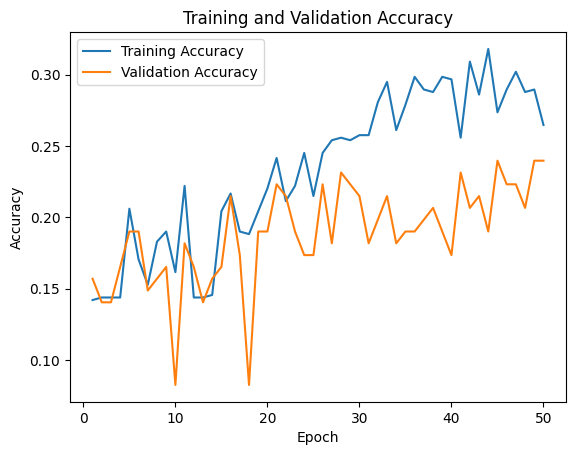

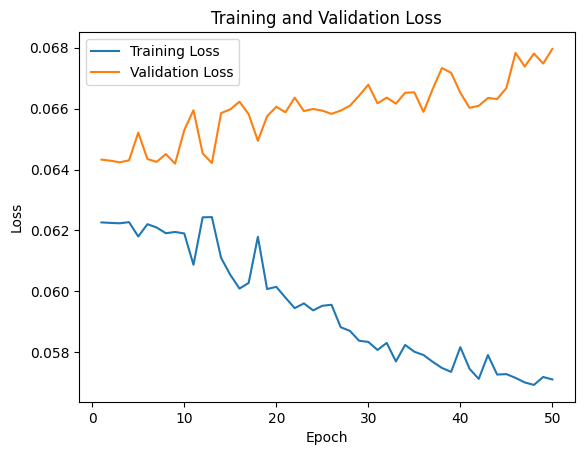

In [ ]:
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import torch
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        outputs = model(data.x, data.edge_index, data.batch)
        _, predicted = torch.max(outputs, 1)
        total += data.y.size(0)
        correct += (predicted == data.y).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on the test set: {accuracy:.2f}%")

Accuracy on the test set: 13.22%
